# **Objetivo del notebook**

En esta etapa vamos a limpiar y preparar los datos: realizaremos una limpieza exhaustiva de los comentarios de texto, eliminando caracteres especiales, convirtiendo el texto a minúsculas y tokenizando las palabras.

Como estamos trabajando con textos y vamos entrenar un modelo de NLP, el preprocesamiento de los datos en este caso consistirá en distintos pasos de limpieza del texto para dejarlo listo para el modelo.



# **Contenido del Notebook**

1. Eliminar columnas innecesarias
2. Regex: Limpieza y filtrado de texto
3. Stopwords: Eliminación de palabras que no aportan
4. Lematización: Normalización de las palabras
5. Funciones de limpieza de texto
6. Prueba con predicción multietiqueta
7. Prueba usando 'IsToxic' como variable objetivo

#### **Instalaciones por si ejecutas el notebook desde  deepnote, o google colab y no creas tu propio entorno virtual**

Por defecto las dejamos comentadas. Quitar el '#' si se desea usarlas.

In [ ]:
#!pip install wordcloud > /dev/null 2>&1

In [ ]:
#!python -m spacy download en_core_web_sm > /dev/null 2>&1

In [ ]:
#!pip xgboost > /dev/null 2>&1

In [ ]:
# Data analysis libraries
import pandas as pd


# Data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Data cleaning
import re
import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English

# Machine learning libraries
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score


In [ ]:
# read csv file
path = "/content/youtoxic_english_1000.csv"
df = pd.read_csv(path)

## **1. Eliminar columnas innecesarias**

In [ ]:
# Eliminamos las columnas que no vamos a utilizar para la predicción
columnas_no_deseadas = ['CommentId', 'VideoId', 'IsRadicalism', 'IsHomophobic']
df = df.drop(columns=columnas_no_deseadas)

'IsRadicalism' y 'IsHomophobic' no tienen ningún 'True', así que no nos valen.

'CommentId' y 'VideoId' no aportan nada relevante.

## **2. Regex: Limpieza y filtrado de texto**

In [ ]:
# Copia de 'df' para contar las palabras y caracteres antes de cualquier limpieza
df_copia = df.copy()

In [ ]:
# Conteo de palabras y caracteres antes de la limpieza
total_caracteres_inicial = df_copia['Text'].str.len().sum()
total_palabras_inicial = df_copia['Text'].str.split().apply(len).sum()

print(f"Total de caracteres inicial: {total_caracteres_inicial}")
print(f"Total de palabras inicial: {total_palabras_inicial}")

Total de caracteres inicial: 185554
Total de palabras inicial: 33776


Creamos una función para limpiar con Regex símbolos y caracteres no .

In [ ]:
# Función para limpiar el texto de símbolos y caracteres indeseados
def limpieza_regex(text):
  text = str(text).lower() # Convierte el texto a minúsculas
  text = re.sub('\n', '', text)  # Elimina saltos de línea
  text = re.sub('\w*\d\w*', '', text)  # Elimina palabras que contienen números
  text = re.sub('\[|\]', '', text) # Elimina corchetes
  text = re.sub(r"\@w+|\#w+",'',text)  # Elimina menciones y hashtags de redes sociales
  text = re.sub('https?://\S+|www\.\S+', '', text)  # Elimina URLs que comiencen con http, https o www
  text = re.sub('<.*?>+', '', text)  # Elimina etiquetas HTML
  text = re.sub(r"[^\w\s]",'',text)  # Elimina caracteres no alfanuméricos
  text = re.sub('\xa0', '', text)  # Elimina el carácter \xa0
  text = re.sub(' +', ' ', text)  # Reemplaza múltiples espacios por uno solo
  text = text.strip() # Elimina espacios antes y despues

  return text

## **3. Stopwords: Eliminación de palabras que no aportan**

Creamos una función que tokeniza con Spacy "en_core_web_sm", y después elimina las stopwords y devuelve una cadena de string.

In [ ]:
# Instanciamos el modelo
nlp_english = spacy.load("en_core_web_sm")

In [ ]:
# Funcion para eliminar Stopwords
def eliminar_stop_words(text):
    doc = nlp_english(text)
    tokens = [token.text for token in doc if not token.is_stop]
    return " ".join(token for token in tokens)

## **4. Lematización: Normalización de las palabras**

Creamos una función que tokeniza con Spacy "en_core_web_sm", y después lematiza y devuelve una cadena de string.

Como vamos a probar ditintas combinaciones de herramientas de limpieza, nos aseguramos de que siempre que se lematice el texto esté previamnete tokenizado. Esto es necesario porque en algunas combinaciones de limpieza definidas más adelante, la función recibirá una cadena de string.

In [ ]:
# Funcion para lematizar
def lematizar_tokens(text):
    doc = nlp_english(text)
    tokens = [token.lemma_ for token in doc]
    return " ".join(tokens)

## **5. Funciones de limpieza de texto**

Creamos varias funciones que aplican distintas combinaciones de técnicas de limpieza para ver cuál funciona mejor con nuestros datos y el modelo elegido.

In [ ]:
def limpieza_1(df):
    df['Text'] = df['Text'].apply(limpieza_regex)
    df['Text'] = df['Text'].apply(eliminar_stop_words)
    df['Text'] = df['Text'].apply(lematizar_tokens)
    return df

def limpieza_2(df):
    df['Text'] = df['Text'].apply(limpieza_regex)
    df['Text'] = df['Text'].apply(eliminar_stop_words)
    return df

def limpieza_3(df):
    df['Text'] = df['Text'].apply(limpieza_regex)
    df['Text'] = df['Text'].apply(lematizar_tokens)
    return df

def limpieza_4(df):
    df['Text'] = df['Text'].apply(limpieza_regex)
    return df

In [ ]:
# Aplicar la función de limpieza que queremos probar

df = limpieza_1(df) # Regex + tokenización + stop words + tokenización + lematización
# df = limpieza_2(df) # Regex + tokenización + stop words
# df = limpieza_3(df) # Regex + tokenización + lematización
# df = limpieza_4(df) # Regex

In [ ]:
df.isnull().sum()

Text               0
IsToxic            0
IsAbusive          0
IsThreat           0
IsProvocative      0
IsObscene          0
IsHatespeech       0
IsRacist           0
IsNationalist      0
IsSexist           0
IsReligiousHate    0
dtype: int64

A la hora de ejecutar la limpieza, le quitaremos el '#' a la función que queremos aplicar y dejaremos las demás comentadas.

In [ ]:
# Imprimimos el texto limpio y convertido a cadena de str
print(df['Text'][0])

people step case not people situation lump mess matter hand make kind protest selfish rational thought investigation guy video heavily emotional hype want hear gets hear press reasonable discussion kudo smerconish keep level time let masri fool dare tear city protest dishonor entire incident hate way police brutality epidemic wish stop pretend like know exactly go s measurable people honestly witness incident clue way issue swung grand jury inform trust majority rule right course action let thank police officer americathat actually serve protect bit jerk pull respect job know people go pout hold accountable action people hate police need officer emergency


In [ ]:
# Conteo de palabras y caracteres después de la limpieza
total_caracteres_final = df['Text'].str.len().sum()
total_palabras_final = df['Text'].str.split().apply(len).sum()

# Mostramos los resultados
print(f"Total de caracteres inicial: {total_caracteres_inicial}")
print(f"Total de palabras inicial: {total_palabras_inicial}")
print(f"Total de caracteres final: {total_caracteres_final}")
print(f"Total de palabras final: {total_palabras_final}")

Total de caracteres inicial: 185554
Total de palabras inicial: 33776
Total de caracteres final: 97854
Total de palabras final: 15304


Visualizamos las palabras más frecuentes en nuestro corpus de textos una vez aplicada la limpieza.

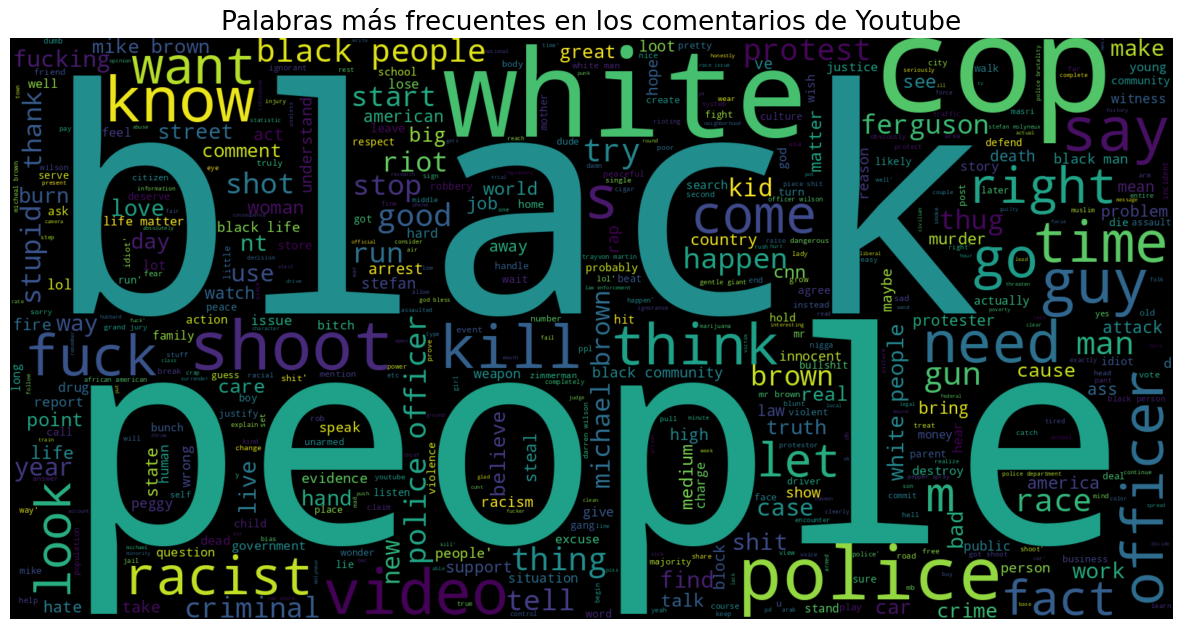

In [ ]:
text = df['Text'].values

# Nube de palabras más frecuentes en los comentarios de Youtube
wordcloud=WordCloud(max_words=500, width=1600, height=800).generate(str(text))
plt.figure(figsize=(15,12), facecolor='None')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Palabras más frecuentes en los comentarios de Youtube", fontsize=19)
plt.show()

## **6. Prueba con predicción multietiqueta**

En vez de predecir sobre una variable objetivo, probaremos a utilizar un modelo multietiqueta que nos de como salida todas las categorías que encajan con el texto que le pasemos.

In [ ]:
df_multioutput = df.copy()

In [ ]:
# Creamos un pipeline con TF-IDF vectorizer y RandomForest con MultiOutputClassifier

pipeline_multioutput = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 3), max_features=4000, min_df=0.01, max_df=25)),
    ('classifier', MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42)))
])

In [ ]:
# Dividimos los datos en conjunto de entrenamiento y prueba
X_multioutput_train, X_multioutput_test, y_multioutput_train, y_multioutput_test = train_test_split(
    df_multioutput['Text'],
    df_multioutput[['IsToxic', 'IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsReligiousHate']],
    test_size=0.2,
    random_state=42
)

In [ ]:
# Entrenamos el modelo con el pipeline
pipeline_multioutput.fit(X_multioutput_train, y_multioutput_train)

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(max_df=0.5, max_features=4000, min_df=0.01,
                                 ngram_range=(1, 3))),
                ('classifier',
                 MultiOutputClassifier(estimator=RandomForestClassifier(n_estimators=200,
                                                                        random_state=42)))])

In [ ]:
# Realizamos predicciones en conjunto de prueba
y_multioutput_test_pred = pipeline_multioutput.predict(X_multioutput_test)

In [ ]:
# Realizamos predicciones en conjunto de entrenamiento
y_multioutput_train_pred = pipeline_multioutput.predict(X_multioutput_train)

In [ ]:
# Imprimimos el classification report y accuracy en conjunto de prueba
print("Classification Report en conjunto de prueba:")
print(classification_report(y_multioutput_test, y_multioutput_test_pred))

Classification Report en conjunto de prueba:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70       107
           1       0.73      0.57      0.64        77
           2       0.00      0.00      0.00         4
           3       0.57      0.21      0.31        38
           4       0.43      0.13      0.20        23
           5       0.67      0.06      0.11        35
           6       1.00      0.03      0.06        30
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         4

   micro avg       0.71      0.40      0.51       321
   macro avg       0.41      0.17      0.20       321
weighted avg       0.69      0.40      0.46       321
 samples avg       0.35      0.23      0.26       321

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score a

In [ ]:
print(f"Accuracy en conjunto de prueba: {accuracy_score(y_multioutput_test, y_multioutput_test_pred):.4f}")

print(f"Accuracy en conjunto de entrenamiento: {accuracy_score(y_multioutput_train, y_multioutput_train_pred):.4f}")

Accuracy en conjunto de prueba: 0.4300
Accuracy en conjunto de entrenamiento: 0.9537


In [ ]:
# Calculamos e imprimimos el accuracy en conjunto de entrenamiento
accuracy_multioutput_train = accuracy_score(y_multioutput_train, y_multioutput_train_pred)
print(f"Accuracy en conjunto de entrenamiento: {accuracy_multioutput_train:.4f}")

Accuracy en conjunto de entrenamiento: 0.9537


In [ ]:
# Calculamos e imprimimos el porcentaje de overfitting
overfitting_percentage_multioutput = (accuracy_multioutput_train - accuracy_score(y_multioutput_test, y_multioutput_test_pred)) * 100
print(f"Porcentaje de Overfitting: {overfitting_percentage_multioutput:.2f}")

Porcentaje de Overfitting: 52.37


In [ ]:
# Comentario de ejemplo
nuevo_comentario = "black lives don't matter"

# Preprocesamiento del comentario utilizando el mismo vectorizador TF-IDF
nuevo_comentario_vectorizado = pipeline_multioutput.named_steps['vectorizer'].transform([nuevo_comentario])

# Realizamos la predicción utilizando el modelo entrenado
prediccion_nuevo_comentario = pipeline_multioutput.predict([nuevo_comentario])

# Mapeamos los valores True/False a los nombres de las columnas
etiquetas = df_multioutput.columns[1:]  # Suponiendo que la primera columna es 'Text'
etiquetas_predichas = [etiqueta for etiqueta, prediccion in zip(etiquetas, prediccion_nuevo_comentario[0]) if prediccion]

# Imprimimos las etiquetas predichas para el nuevo comentario
print("Etiquetas predichas para el nuevo comentario:", etiquetas_predichas)

Etiquetas predichas para el nuevo comentario: ['IsToxic']


In [ ]:
# Comentario de ejemplo
nuevo_comentario = "I would LOVE to see this pussy go to Staten Island and spit on a cop. I would LOVE to see it happen. Mike Brown was a strong arm thug and people are burning Ferguson down. Eric Garnier did nothing wrong and was choked to death. No protest on mafia controlled Staten Island. No burning cars. Nothing."

# Preprocesamiento del comentario utilizando el mismo vectorizador TF-IDF
nuevo_comentario_vectorizado = pipeline_multioutput.named_steps['vectorizer'].transform([nuevo_comentario])

# Realizamos la predicción utilizando el modelo entrenado
prediccion_nuevo_comentario = pipeline_multioutput.predict([nuevo_comentario])

# Mapeamos los valores True/False a los nombres de las columnas
etiquetas = df_multioutput.columns[1:]  # Suponiendo que la primera columna es 'Text'
etiquetas_predichas = [etiqueta for etiqueta, prediccion in zip(etiquetas, prediccion_nuevo_comentario[0]) if prediccion]

# Imprimimos las etiquetas predichas para el nuevo comentario
print("Etiquetas predichas para el nuevo comentario:", etiquetas_predichas)

Etiquetas predichas para el nuevo comentario: ['IsToxic', 'IsAbusive', 'IsObscene', 'IsHatespeech', 'IsRacist']


**Observaciones:**

**Prueba 1:**

Al entrenar el modelo multietiqueta habiendo limpiado los datos con la limpieza_1 (regex, tokenización, stop words y lematización) se obtuvieron los siguientes resultados:

- Accuracy en train: 0.99
- Accuracy en test: 0.45
- Overfitting: 54.50%
- Etiquetas predichas en el primer ejemplo: 0
- Etiquetas predichas en el segundo ejemplo: 0

.


**Prueba 2:**

Al entrenar el modelo multietiqueta habiendo limpiado los datos con la limpieza_4 (sólo regex) se obtuvieron los siguientes resultados:

- Accuracy en train: 0.99
- Accuracy en test: 0.46
- Overfitting: 53.25%
- Etiquetas predichas en el primer ejemplo: ['IsToxic', 'IsAbusive']
- Etiquetas predichas en el segundo ejemplo: ['IsToxic', 'IsAbusive', 'IsObscene', 'IsHatespeech', 'IsRacist']

.


**Conclusiones:**
Las columnas están tan desbalanceadas que el modelo no pedice bien. Se aprende muy bien los datos de entrenamiento, pero no funciona bien con los de test, teniendo así un overfitting altísimo.

Hay muy poquitos ejemplos para "True" y cuanto menos se limpian los datos más qtiquetas predice, quizá porque al tener más palabras (aunque no sean con información relevante) se las puede aprender. Pero esto solo funciona si le pasas textos muy similares a con los que se ha entrenado, en el resto de casos sigue sin predecir bien.

Se podría intentar balancear los datos con técnicas de balanceo, pero no le vemos mucho sentido, prácticamente todo el dataset serían datos sintéticos.

El hecho de poder clasificar con multietiqueta, aunque es interesante, en este caso no es imprescindible. Nos basta con saber si es discurso de odio no, así que finalmente usaremos la columna 'IsToxic' como variable objetivo.



## **7. Prueba usando 'IsToxic' como variable objetivo**

Probaremos ahora a hacer una clasificación binaria usando 'IsToxic' como variable objetivo por 2 motivos:

1. Para cada fila, siempre que hay algún 'True' en alguna columna, 'IsToxic' es True. Cuando no hay ningún True en ninguna de las columnas restantes, 'IsToxic' es False. Esto nos lleva adeducir que 'IsToxic' es una columna creada a partir de todas las demás y que por tanto reúne y refleja a las demás.

2. Está bastante balanceada: 462 True y 538 False.



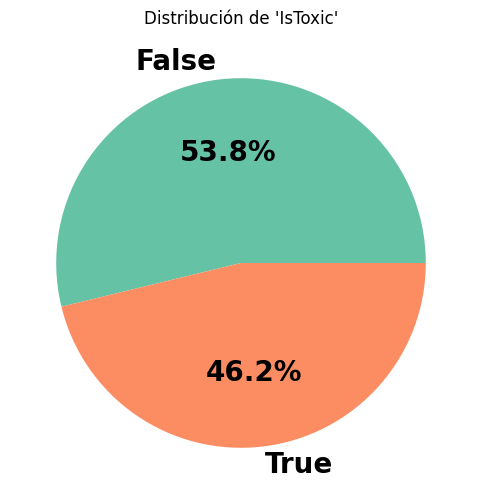

In [ ]:
plt.figure(figsize=(10,6))
plt.pie(df["IsToxic"].value_counts(),labels=df["IsToxic"].value_counts().keys(),autopct="%1.1f%%",
       textprops={"fontsize":20,"fontweight":"black"},colors=sns.color_palette("Set2"))
plt.title("Distribución de 'IsToxic'")
plt.show()

In [ ]:
df.head()

,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsReligiousHate
0,people step case not people situation lump mes...,False,False,False,False,False,False,False,False,False,False
1,law enforcement train shoot apprehend train sh...,True,True,False,False,False,False,False,False,False,False
2,not reckon black life matter banner hold white...,True,True,False,False,True,False,False,False,False,False
3,large number people like police officer call c...,False,False,False,False,False,False,False,False,False,False
4,arab dude absolutely right shot extra time sho...,False,False,False,False,False,False,False,False,False,False


In [ ]:
# Eliminamos las columnas que no vamos a utilizar para la predicción
columnas_no_deseadas = ['IsAbusive', 'IsThreat', 'IsProvocative', 'IsObscene', 'IsHatespeech', 'IsRacist', 'IsNationalist', 'IsSexist', 'IsReligiousHate']
df = df.drop(columns=columnas_no_deseadas)

In [ ]:
df.head()

,Text,IsToxic
0,people step case not people situation lump mes...,False
1,law enforcement train shoot apprehend train sh...,True
2,not reckon black life matter banner hold white...,True
3,large number people like police officer call c...,False
4,arab dude absolutely right shot extra time sho...,False


Al eliminar stopwords puede que alguna fila que tuviese pocas palabras haya quedado solamente con espacios. Las buscamos para eliminarlas, ya que al guardar los datos limpios en un nuevo csv, esas columnas con espacios pasarán a convertirseen valores nulos.

In [ ]:
# Verificar si hay filas en blanco
filas_en_blanco = df[df['Text'].str.len() == 0]
print(filas_en_blanco)

    Text  IsToxic
111         False


In [ ]:
print(df.iloc[111])

Text            
IsToxic    False
Name: 111, dtype: object


In [ ]:
# Eliminamos la fila 111
df = df.drop(111)

# Nos aseguramos de que los índices estén actualizados
df.reset_index(drop=True, inplace=True)

In [ ]:
# Verificamos si hay filas en blanco
filas_en_blanco = df[df['Text'].str.len() == 0]
print(filas_en_blanco)

Empty DataFrame
Columns: [Text, IsToxic]
Index: []


In [ ]:
df.to_csv("cleaned_youtoxic.csv",index=False)

### **Pipeline con vectorización TF-IDF y modelo**

In [ ]:
# Preparación de datos para el modelo
X = df['Text']
y = df['IsToxic']

In [ ]:
# Creamos un nuevo pipeline con TfidfVectorizer y GradientBoostingClassifier
pipeline_model = Pipeline([
    ('vectorizer', TfidfVectorizer()),
    ('classifier', XGBClassifier())
])

In [ ]:
# División de los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Entrenamos el modelo con el pipeline
pipeline_model.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [ ]:
# Realizamos predicciones en conjunto de prueba
y_test_pred = pipeline_model.predict(X_test)

# Realizamos predicciones en conjunto de entrenamiento
y_train_pred = pipeline_model.predict(X_train)

In [ ]:
# Imprimimos el classification report y accuracy en conjunto de prueba
print("Classification Report en conjunto de prueba:")
print(classification_report(y_test, y_test_pred))
print(f"Accuracy en conjunto de prueba: {accuracy_score(y_test, y_test_pred):.4f}")

# Calculamos e imprimimos el accuracy en conjunto de entrenamiento
accuracy_train = accuracy_score(y_train, y_train_pred)
print(f"Accuracy en conjunto de entrenamiento: {accuracy_train:.4f}")

# Calculamos e imprimimos el porcentaje de overfitting
overfitting_percentage = (accuracy_train - accuracy_score(y_test, y_test_pred)) * 100
print(f"Porcentaje de Overfitting: {overfitting_percentage:.2f}%")

Classification Report en conjunto de prueba:
              precision    recall  f1-score   support

       False       0.66      0.77      0.71       108
        True       0.67      0.54      0.60        92

    accuracy                           0.67       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.67      0.67      0.66       200

Accuracy en conjunto de prueba: 0.6650
Accuracy en conjunto de entrenamiento: 0.9437
Porcentaje de Overfitting: 27.87%


En el archivo Modeling.ipynb ajustaremos los hiperparámetros de TfidfVectorizer y de XGBClassifier para mejorar el accuracy y el overfitting.

Métricas finales con hiperparámetros:

Accuracy en conjunto de prueba: 0.6950

Accuracy en conjunto de entrenamiento: 0.7422

Porcentaje de Overfitting: 4.72%



**Conclusiones**

Al tener tan pocos datos es difícil reducir el overfitting.

Se nos ocurren 2 alternativas:

Una opción interesante de probar sería aumentar el conjunto de datos uniendo el dataset inicial a algún otro que contenga mensajes de odio.

Otra opción sería probar algún modelo preentrenado de hugging face, de manera que la escasez de datos no afectara al entrenamiento.